# Import required dependencies

In [70]:
import re
import os
import io
import json

In [72]:
import zipfile
import requests
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer, tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences

print(tf.__version__)

2.4.1


# Prepare dataset and configuration

In [ ]:
OUT_OF_VOCABULARY = '<OOV>'
LENGTH_TO_CONSIDER = 30

In [ ]:
file_name = 'source_code.txt'
file_url = 'https://github.com/Pittawat2542/dart-ml-autocomplete/raw/master/dataset_collector/source_code.txt'
r = requests.get(file_url, allow_redirects=True)
open(file_name, 'wb').write(r.content)

5148815

In [ ]:
dart_keywords = ["abstract", "else", "import", "super", "as", "enum", "in", "switch", "assert", "export", "interface", "sync", "async", "extends", "is", "this", "await", "extension", "library", "throw", "break", "external", "mixin", "true", "case", "factory", "new", "try", "catch", "false", "null", "typedef", "class", "final", "on", "var", "const", "finally", "operator", "void", "continue", "for", "part", "while", "covariant", "Function", "rethrow", "with", "default", "get", "return", "yield", "deferred", "hide", "set", "do", "if", "show", "dynamic", "implements", "static"]
dart_operators = [";", ">", "<", ">=", "<=", "==", "!=", "=", "(", ")", "[", "]", "{", "}", "&&", "||", "!", "&", "|", "^", "~", "++", "--", ".", "?.", "+", "-", "*", "/", "%", "+=", "-=", "*=", "/=", "%=", "~/", ">>", "<<", ">>>", "?", ":", "..", "?..", "^=", "&=", "|=", "??", "=>"]
training_data = open(file_name, 'rb').read().decode(encoding='utf-8')

In [ ]:
type_classification_labels = ['KEYWORD', 'OPERATOR', 'SPACE', 'NEWLINE', 'DICTIONARY']

keyword_classification_labels = [w for w in dart_keywords]
keyword_classification_labels.append(OUT_OF_VOCABULARY)

operator_classification_labels = [w for w in dart_operators]
operator_classification_labels.append(OUT_OF_VOCABULARY)

In [ ]:
training_data = re.sub(r"//.*", "", training_data) # remove comment
training_data = re.sub(r"import.*", "", training_data) # remove import
training_data = re.sub(r"export.*", "", training_data) # remove export
training_data = re.sub(r"^(?:[\t ]*(?:\r?\n|\r))+", "", training_data) # remove blank line
training_data = re.sub(r"^(\s*\r\n){2,}", "\r\n", training_data) # replace multiple blank lines with one
training_data = re.sub(r"^\s*$", "", training_data) # remove line with only spaces
training_data = training_data.replace('\n', '').replace(';', ';\n')
print(training_data[:250])

final Context posix = Context(style: Style.posix);
final Context windows = Context(style: Style.windows);
final Context url = Context(style: Style.url);
final Context context = createInternal();
Style get style => context.style;
String get current { 


# Prepare dataset for model training

In [ ]:
training_data_arr = list(filter(None, re.split(r'( |\n|:|\.|[()])', training_data)))

In [ ]:
type_classification_dataset = {
    'Text': [],
    'Label': []
}

for i in range(0, len(training_data_arr) - LENGTH_TO_CONSIDER, 30):
  next_word = training_data_arr[i+LENGTH_TO_CONSIDER]
  label = ''
  if next_word in dart_keywords:
    label = 0
  elif next_word in dart_operators:
    label = 1
  elif next_word == ' ':
    label = 2
  elif next_word == '\n':
    label = 3
  else:
    label = 4
  
  type_classification_dataset['Text'].append(''.join(training_data_arr[i:i+LENGTH_TO_CONSIDER]))
  type_classification_dataset['Label'].append(label)

type_classification_dataset = pd.DataFrame(type_classification_dataset)
type_target = type_classification_dataset.pop('Label')
type_dataset = tf.data.Dataset.from_tensor_slices((type_classification_dataset.values, type_target.values))

In [ ]:
keyword_classification_dataset = {
    'Text': [],
    'Label': []
}

training_data_arr_temp = [w for w in training_data_arr]

for i, word in enumerate(training_data_arr_temp):
  if word not in dart_keywords:
    training_data_arr_temp[i] = OUT_OF_VOCABULARY

for i in range(0, len(training_data_arr_temp) - LENGTH_TO_CONSIDER, 30):
  next_word = training_data_arr_temp[i+LENGTH_TO_CONSIDER]
  if next_word != OUT_OF_VOCABULARY:
    keyword_classification_dataset['Text'].append(''.join(training_data_arr_temp[i:i+LENGTH_TO_CONSIDER]))
    keyword_classification_dataset['Label'].append(keyword_classification_labels.index(next_word))

keyword_classification_dataset = pd.DataFrame(keyword_classification_dataset)
keyword_target = keyword_classification_dataset.pop('Label')
keyword_dataset = tf.data.Dataset.from_tensor_slices((keyword_classification_dataset.values, keyword_target.values))

In [ ]:
operator_classification_dataset = {
    'Text': [],
    'Label': []
}

training_data_arr_temp = [w for w in training_data_arr]

for i, word in enumerate(training_data_arr_temp):
  if word not in dart_operators:
    training_data_arr_temp[i] = OUT_OF_VOCABULARY

for i in range(0, len(training_data_arr_temp) - LENGTH_TO_CONSIDER, 30):
  next_word = training_data_arr_temp[i+LENGTH_TO_CONSIDER]
  if next_word != OUT_OF_VOCABULARY:
    operator_classification_dataset['Text'].append(''.join(training_data_arr_temp[i:i+LENGTH_TO_CONSIDER]))
    operator_classification_dataset['Label'].append(operator_classification_labels.index(next_word))

operator_classification_dataset = pd.DataFrame(operator_classification_dataset)
operator_target = operator_classification_dataset.pop('Label')
operator_dataset = tf.data.Dataset.from_tensor_slices((operator_classification_dataset.values, operator_target.values))

In [ ]:
#@title
dictionary_classification_dataset = {
    'Text': [],
    'Label': []
}

training_data_arr_temp = [w for w in training_data_arr]

for i, word in enumerate(training_data_arr_temp):
  if word in dart_keywords or word in dart_operators or word == ' ' or word == '\n':
    training_data_arr_temp[i] = OUT_OF_VOCABULARY

for i in range(0, len(training_data_arr_temp) - LENGTH_TO_CONSIDER, 30):
  dictionary_classification_dataset['Text'].append(''.join(training_data_arr_temp[i:i+LENGTH_TO_CONSIDER]))
  dictionary_classification_dataset['Label'].append(training_data_arr_temp[i+LENGTH_TO_CONSIDER])

dictionary_classification_dataset = pd.DataFrame(dictionary_classification_dataset)

dictionary_target = dictionary_classification_dataset.pop('Label')

dictionary_dataset = tf.data.Dataset.from_tensor_slices((dictionary_classification_dataset.values, dictionary_target.values))

# Modeling

In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_' + metric], '')
  plt.xlabel('Epochs')
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [ ]:
def plot_loss_acc(history):
  plt.figure(figsize=(16, 8))
  plt.subplot(1, 2, 1)
  plot_graphs(history, 'accuracy')
  plt.ylim(None, 1)
  plt.subplot(1, 2, 2)
  plot_graphs(history, 'loss')
  plt.ylim(0, None)

In [ ]:
embedding_dim = 32
max_length = LENGTH_TO_CONSIDER
trunc_type='post'
padding_type='post'
oov_tok = '<OOV>'
num_epochs = 30

## Type classification

In [ ]:
type_vocab_size = 1000

In [ ]:
type_sentences = type_classification_dataset['Text'].tolist()
type_labels = type_target.tolist()

type_training_size = int(len(type_sentences) * 0.8)
type_training_text = type_sentences[:type_training_size]
type_validation_text = type_sentences[type_training_size:]
type_training_labels = np.array(type_labels[:type_training_size])
type_validation_labels = np.array(type_labels[type_training_size:])

In [ ]:
type_tokenizer = Tokenizer(num_words=type_vocab_size, oov_token=oov_tok)
type_tokenizer.fit_on_texts(type_training_text)

In [ ]:
type_training_sequences = type_tokenizer.texts_to_sequences(type_training_text)
type_training_padded = pad_sequences(type_training_sequences, maxlen=max_length, padding=padding_type, 
                       truncating=trunc_type)

In [ ]:
type_validation_sequences = type_tokenizer.texts_to_sequences(type_validation_text)
type_validation_padded = pad_sequences(type_validation_sequences, maxlen=max_length, 
                               padding=padding_type, truncating=trunc_type)

In [ ]:
type_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(type_vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(type_classification_labels))
])

type_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])
type_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 32)            32000     
_________________________________________________________________
flatten (Flatten)            (None, 960)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               123008    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 325       
Total params: 163,589
Trainable params: 163,589
Non-trainable params: 0
_________________________________________________________________


In [ ]:
type_history = type_model.fit(type_training_padded, type_training_labels, epochs=num_epochs, validation_data=(type_validation_padded, type_validation_labels))

Epoch 1/30
1261/1261 [==============================] - 6s 4ms/step - loss: 0.8455 - accuracy: 0.6888 - val_loss: 0.7201 - val_accuracy: 0.6551
Epoch 2/30
1261/1261 [==============================] - 5s 4ms/step - loss: 0.6591 - accuracy: 0.7219 - val_loss: 0.6417 - val_accuracy: 0.6794
Epoch 3/30
1261/1261 [==============================] - 5s 4ms/step - loss: 0.5880 - accuracy: 0.7385 - val_loss: 0.6116 - val_accuracy: 0.6845
Epoch 4/30
1261/1261 [==============================] - 5s 4ms/step - loss: 0.5453 - accuracy: 0.7528 - val_loss: 0.6072 - val_accuracy: 0.6880
Epoch 5/30
1261/1261 [==============================] - 5s 4ms/step - loss: 0.5163 - accuracy: 0.7625 - val_loss: 0.6044 - val_accuracy: 0.6918
Epoch 6/30
1261/1261 [==============================] - 5s 4ms/step - loss: 0.4862 - accuracy: 0.7747 - val_loss: 0.6172 - val_accuracy: 0.6877
Epoch 7/30
1261/1261 [==============================] - 5s 4ms/step - loss: 0.4727 - accuracy: 0.7774 - val_loss: 0.6192 - val_accuracy:

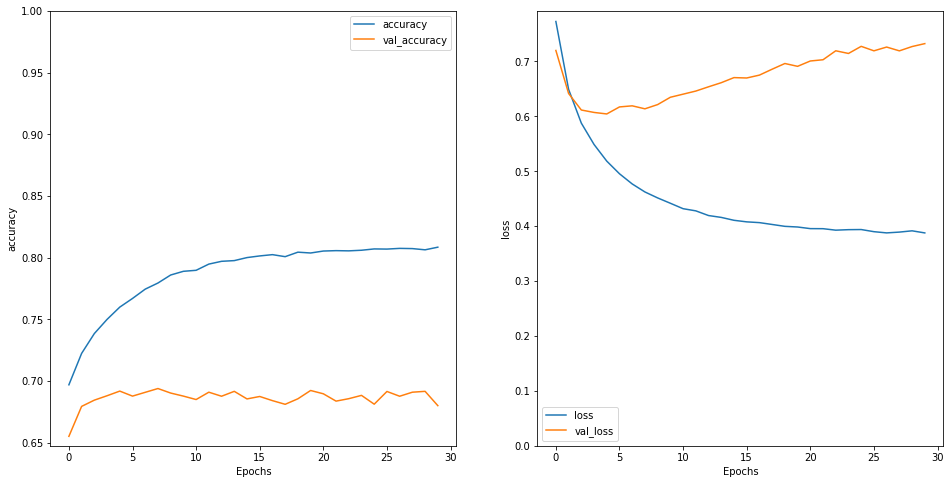

In [ ]:
plot_loss_acc(type_history)

In [ ]:
type_probability_model = tf.keras.Sequential([type_model, 
                                         tf.keras.layers.Softmax()])

## Keyword classification

In [ ]:
keyword_vocab_size = len(dart_keywords) + 1

In [ ]:
keyword_sentences = keyword_classification_dataset['Text'].tolist()
keyword_labels = keyword_target.tolist()

keyword_training_size = int(len(keyword_sentences) * 0.8)
keyword_training_text = keyword_sentences[:keyword_training_size]
keyword_validation_text = keyword_sentences[keyword_training_size:]
keyword_training_labels = np.array(keyword_labels[:keyword_training_size])
keyword_validation_labels = np.array(keyword_labels[keyword_training_size:])

In [ ]:
keyword_tokenizer = Tokenizer(num_words=keyword_vocab_size, oov_token=oov_tok)
keyword_tokenizer.fit_on_texts(keyword_training_text)

In [ ]:
keyword_training_sequences = keyword_tokenizer.texts_to_sequences(keyword_training_text)
keyword_training_padded = pad_sequences(keyword_training_sequences, maxlen=max_length, padding=padding_type, 
                       truncating=trunc_type)

In [ ]:
keyword_validation_sequences = keyword_tokenizer.texts_to_sequences(keyword_validation_text)
keyword_validation_padded = pad_sequences(keyword_validation_sequences, maxlen=max_length, 
                               padding=padding_type, truncating=trunc_type)

In [ ]:
keyword_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(keyword_vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(keyword_vocab_size)
])

keyword_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])
keyword_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 32)            1984      
_________________________________________________________________
flatten_1 (Flatten)          (None, 960)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               123008    
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 62)                4030      
Total params: 137,278
Trainable params: 137,278
Non-trainable params: 0
_________________________________________________________________


In [ ]:
keyword_history = keyword_model.fit(keyword_training_padded, keyword_training_labels, epochs=num_epochs, validation_data=(keyword_validation_padded, keyword_validation_labels))

Epoch 1/30
13/13 [==============================] - 1s 21ms/step - loss: 4.0333 - accuracy: 0.2659 - val_loss: 3.7120 - val_accuracy: 0.0000e+00
Epoch 2/30
13/13 [==============================] - 0s 7ms/step - loss: 3.3091 - accuracy: 0.3634 - val_loss: 3.3587 - val_accuracy: 0.0000e+00
Epoch 3/30
13/13 [==============================] - 0s 7ms/step - loss: 2.6091 - accuracy: 0.3684 - val_loss: 2.6472 - val_accuracy: 0.0000e+00
Epoch 4/30
13/13 [==============================] - 0s 8ms/step - loss: 2.5207 - accuracy: 0.3747 - val_loss: 2.3857 - val_accuracy: 0.0000e+00
Epoch 5/30
13/13 [==============================] - 0s 8ms/step - loss: 2.3563 - accuracy: 0.3664 - val_loss: 2.1808 - val_accuracy: 0.0000e+00
Epoch 6/30
13/13 [==============================] - 0s 7ms/step - loss: 2.2797 - accuracy: 0.3659 - val_loss: 2.2496 - val_accuracy: 0.0000e+00
Epoch 7/30
13/13 [==============================] - 0s 7ms/step - loss: 2.2518 - accuracy: 0.3731 - val_loss: 2.2343 - val_accuracy: 0.

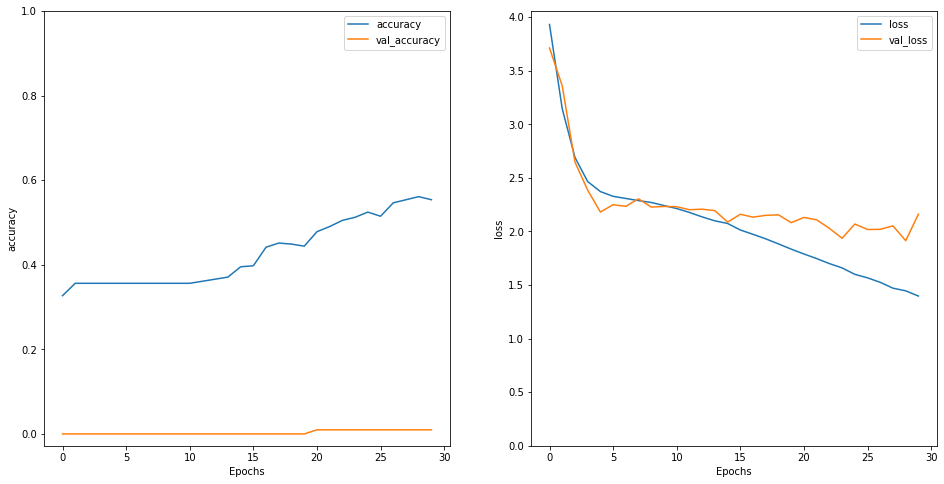

In [ ]:
plot_loss_acc(keyword_history)

In [ ]:
keyword_probability_model = tf.keras.Sequential([keyword_model, 
                                         tf.keras.layers.Softmax()])

## Operator classification

In [ ]:
operator_vocab_size = len(dart_operators) + 1

In [ ]:
operator_sentences = operator_classification_dataset['Text'].tolist()
operator_labels = operator_target.tolist()

operator_training_size = int(len(operator_sentences) * 0.8)
operator_training_text = operator_sentences[:operator_training_size]
operator_validation_text = operator_sentences[operator_training_size:]
operator_training_labels = np.array(operator_labels[:operator_training_size])
operator_validation_labels = np.array(operator_labels[operator_training_size:])

In [ ]:
operator_tokenizer = Tokenizer(num_words=operator_vocab_size, oov_token=oov_tok)
operator_tokenizer.fit_on_texts(operator_training_text)

In [ ]:
operator_training_sequences = operator_tokenizer.texts_to_sequences(operator_training_text)
operator_training_padded = pad_sequences(operator_training_sequences, maxlen=max_length, padding=padding_type, 
                       truncating=trunc_type)

In [ ]:
operator_validation_sequences = operator_tokenizer.texts_to_sequences(operator_validation_text)
operator_validation_padded = pad_sequences(operator_validation_sequences, maxlen=max_length, 
                               padding=padding_type, truncating=trunc_type)

In [ ]:
operator_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(operator_vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(operator_vocab_size)
])

operator_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])
operator_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 32)            1568      
_________________________________________________________________
flatten_2 (Flatten)          (None, 960)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               123008    
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 49)                3185      
Total params: 136,017
Trainable params: 136,017
Non-trainable params: 0
_________________________________________________________________


In [ ]:
operator_history = operator_model.fit(operator_training_padded, operator_training_labels, epochs=num_epochs, validation_data=(operator_validation_padded, operator_validation_labels))

Epoch 1/30
166/166 [==============================] - 1s 5ms/step - loss: 2.3865 - accuracy: 0.3403 - val_loss: 1.5477 - val_accuracy: 0.5173
Epoch 2/30
166/166 [==============================] - 1s 4ms/step - loss: 1.5470 - accuracy: 0.4557 - val_loss: 1.3133 - val_accuracy: 0.5053
Epoch 3/30
166/166 [==============================] - 1s 4ms/step - loss: 1.4339 - accuracy: 0.5004 - val_loss: 1.2305 - val_accuracy: 0.5317
Epoch 4/30
166/166 [==============================] - 1s 4ms/step - loss: 1.3758 - accuracy: 0.5071 - val_loss: 1.2415 - val_accuracy: 0.5317
Epoch 5/30
166/166 [==============================] - 1s 4ms/step - loss: 1.3984 - accuracy: 0.4938 - val_loss: 1.2031 - val_accuracy: 0.5317
Epoch 6/30
166/166 [==============================] - 1s 4ms/step - loss: 1.3660 - accuracy: 0.5001 - val_loss: 1.2035 - val_accuracy: 0.5317
Epoch 7/30
166/166 [==============================] - 1s 4ms/step - loss: 1.3427 - accuracy: 0.4977 - val_loss: 1.1829 - val_accuracy: 0.5324
Epoch 

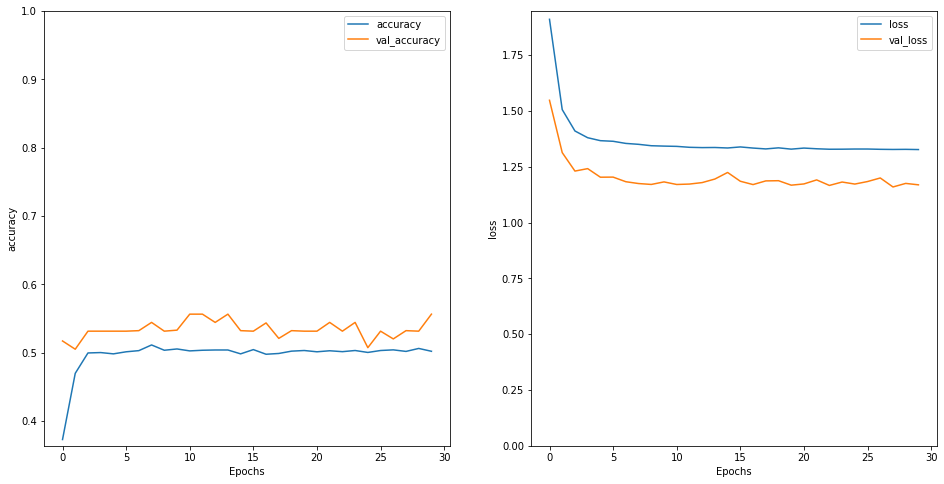

In [ ]:
plot_loss_acc(operator_history)

In [ ]:
operator_probability_model = tf.keras.Sequential([operator_model, 
                                         tf.keras.layers.Softmax()])

## Exporting models

In [ ]:
def zipdir(path, ziph):
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file), 
                       os.path.relpath(os.path.join(root, file), 
                                       os.path.join(path, '..')))

In [ ]:
type_probability_model.save('type_model')

INFO:tensorflow:Assets written to: type_model/assets


In [ ]:
zipf = zipfile.ZipFile('type_model.zip', 'w', zipfile.ZIP_DEFLATED)
zipdir('type_model/', zipf)

In [ ]:
keyword_probability_model.save('keyword_model')

INFO:tensorflow:Assets written to: keyword_model/assets


In [ ]:
zipf = zipfile.ZipFile('keyword_model.zip', 'w', zipfile.ZIP_DEFLATED)
zipdir('keyword_model/', zipf)

In [ ]:
operator_probability_model.save('operator_model')

INFO:tensorflow:Assets written to: operator_model/assets


In [ ]:
zipf = zipfile.ZipFile('operator_model.zip', 'w', zipfile.ZIP_DEFLATED)
zipdir('operator_model/', zipf)

In [ ]:
zipf.close()

In [34]:
type_tokenizer_json = type_tokenizer.to_json()
with io.open('type_tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(type_tokenizer_json, ensure_ascii=False))

In [ ]:
keyword_tokenizer_json = keyword_tokenizer.to_json()
with io.open('keyword_tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(keyword_tokenizer_json, ensure_ascii=False))

In [ ]:
operator_tokenizer_json = operator_tokenizer.to_json()
with io.open('operator_tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(operator_tokenizer_json, ensure_ascii=False))

## Combining result

In [39]:
def download(file_name, url):
  r = requests.get(url, allow_redirects=True)
  open(file_name, 'wb').write(r.content)

In [40]:
def unzip(file_name):
  zip_ref = zipfile.ZipFile(file_name, "r")
  zip_ref.extractall()
  zip_ref.close()

In [41]:
def download_and_unzip(file_name, url):
  download(file_name, url)
  unzip(file_name)

In [48]:
def initilize_model_from_internet():
  github_url = 'https://github.com/Pittawat2542/dart-ml-autocomplete/raw/master/'
  type_model_name = 'type_model_v2.zip'
  keyword_model_name = 'keyword_model_v2.zip'
  operator_model_name = 'operator_model_v2.zip'
  type_tokenizer_name = 'type_tokenizer.json'
  keyword_tokenizer_name = 'keyword_tokenizer.json'
  operator_tokenizer_name = 'operator_tokenizer.json'

  download_and_unzip(type_model_name, f'{github_url}{type_model_name}')
  download_and_unzip(keyword_model_name, f'{github_url}{keyword_model_name}')
  download_and_unzip(operator_model_name, f'{github_url}{operator_model_name}')
  download(type_tokenizer_name, f'{github_url}{type_tokenizer_name}')
  download(keyword_tokenizer_name, f'{github_url}{keyword_tokenizer_name}')
  download(operator_tokenizer_name, f'{github_url}{operator_tokenizer_name}')

In [53]:
def get_models():
  loaded_type_model = tf.keras.models.load_model('type_model', compile=False)
  loaded_keyword_model = tf.keras.models.load_model('keyword_model', compile=False)
  loaded_operator_model = tf.keras.models.load_model('operator_model', compile=False)

  return (loaded_type_model, loaded_keyword_model, loaded_operator_model)

In [44]:
def get_tokenizers():
  with open('type_tokenizer.json') as f:
    data = json.load(f)
    loaded_type_tokenizer = tokenizer_from_json(data)

  with open('keyword_tokenizer.json') as f:
    data = json.load(f)
    loaded_keyword_tokenizer = tokenizer_from_json(data)

  with open('operator_tokenizer.json') as f:
    data = json.load(f)
    loaded_operator_tokenizer = tokenizer_from_json(data)

  return (loaded_type_tokenizer, loaded_keyword_tokenizer, loaded_operator_tokenizer)

In [45]:
def predict_next_n_words(text, n):
  loaded_type_model, loaded_keyword_model, loaded_operator_model = get_models()
  loaded_type_tokenizer, loaded_keyword_tokenizer, loaded_operator_tokenizer = get_tokenizers()
  
  t = list(filter(None, re.split(r'( |\n|:|\.|[()])', text)))
  for i in range(n):
    input_text = ''.join(t)
    sequences = loaded_type_tokenizer.texts_to_sequences([input_text])
    padded = pad_sequences(sequences, padding=padding_type, maxlen=max_length)
    predicted_type = type_classification_labels[np.argmax(loaded_type_model.predict(padded))]

    next_word = ''
    if predicted_type == 'SPACE':
      next_word = ' '
    elif predicted_type == 'NEWLINE':
      next_word = '\n'
    elif predicted_type == 'KEYWORD':
      sequences = loaded_keyword_tokenizer.texts_to_sequences([input_text])
      padded = pad_sequences(sequences, padding=padding_type, maxlen=max_length)
      next_word = keyword_classification_labels[np.argmax(loaded_keyword_model.predict(padded))]
    elif predicted_type == 'OPERATOR':
      sequences = loaded_operator_tokenizer.texts_to_sequences([input_text])
      padded = pad_sequences(sequences, padding=padding_type, maxlen=max_length)
      next_word = operator_classification_labels[np.argmax(loaded_operator_model.predict(padded))]
    else:
      next_word = OUT_OF_VOCABULARY
    
    t.append(next_word)

  return ''.join(t)

In [60]:
def get_next_word_top_n(text, n):
  loaded_type_model, loaded_keyword_model, loaded_operator_model = get_models()
  loaded_type_tokenizer, loaded_keyword_tokenizer, loaded_operator_tokenizer = get_tokenizers()

  next_words = []
  sequences = loaded_type_tokenizer.texts_to_sequences([text])
  padded = pad_sequences(sequences, padding=padding_type, maxlen=max_length)
  predicted_type = loaded_type_model.predict(padded)

  sequences = loaded_keyword_tokenizer.texts_to_sequences([text])
  padded = pad_sequences(sequences, padding=padding_type, maxlen=max_length)
  keyword_predictions = loaded_keyword_model.predict(padded)

  sequences = loaded_operator_tokenizer.texts_to_sequences([text])
  padded = pad_sequences(sequences, padding=padding_type, maxlen=max_length)
  operator_predictions = loaded_operator_model.predict(padded)

  for i, pred in enumerate(keyword_predictions[0]):
    result = (keyword_classification_labels[i], pred * predicted_type[0][0])
    next_words.append(result)
  
  for i, pred in enumerate(operator_predictions[0]):
    result = (operator_classification_labels[i], pred * predicted_type[0][1])
    next_words.append(result)

  space_result = (' ', predicted_type[0][2])
  next_words.append(space_result)

  newline_result = ('\n', predicted_type[0][3])
  next_words.append(newline_result)

  oov_result = (OUT_OF_VOCABULARY, predicted_type[0][4])
  next_words.append(oov_result) 

  next_words.sort(key=lambda x: x[1], reverse=True)

  if (len(next_words) < n):
    return next_words

  return next_words[:n]

# Predicting

In [56]:
initilize_model_from_internet()

In [57]:
test_text = 'const icon = IconData('

In [63]:
result = predict_next_n_words(test_text, 1)
print(f'Input: \'{test_text}\'')
print(f'Output: \'{result}\'')

Input: 'const icon = IconData('
Output: 'const icon = IconData( '


In [73]:
results = get_next_word_top_n('const icon = IconData(', 10)
print(f'Input: \'{test_text}\'')
print('Output:')
for i, (word, prediction) in enumerate(results):
  print(f'{i + 1}: \'{word}\' - {round(prediction * 100, 2)}%')

Input: 'const icon = IconData('
Output:
1: ' ' - 88.49%
2: ')' - 2.64%
3: ';' - 1.39%
4: '(' - 0.81%
5: 'const' - 0.65%
6: 'return' - 0.34%
7: 'final' - 0.3%
8: 'if' - 0.28%
9: 'this' - 0.25%
10: '.' - 0.23%
